### Thesis Implementation  
###### Data Interpolation For Multivariable And Multivariate Time Series Data 


###### importing libraries

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from random import randint # generates random integers
import random

from sklearn.metrics import r2_score, mean_squared_error
# For generating metrics for machine learning models

from sklearn.impute import SimpleImputer 
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
# Has stratergies such as mean,median


# Iterative imputer assumes each feature X and one target feature feature Y.
# Applies regression on the demanded the iterations in round robin format

from datetime import datetime
from dateutil.parser import parse 
# To read general formats of dates

from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
# Machine learning models used for test

from sklearn.pipeline import make_pipeline
# To make pipeline but not used in the code

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
# Standard scalar for scaling numerical columns

from sklearn.preprocessing import OneHotEncoder
# One hot encoding for handling categorical variables

###### Importing constants

In [2]:
import util
# Function defination file

CV = 5
# This is used to decide the K of K-fold cross validation

HOLE_PERCENT = 0.3
# Decide the missing data for a matrix

RESHAPE_FACTOR = -1
#RESHAPE_FACTOR = 10


# -1 means use first available factor to reshape
# or you can mannualy decide the reshape factor

ROW_BASED_RESHAPE = False
# If ROW_BASED_RESHAPE = False, then this is col-based LGDI
# If ROW_BASED_RESHAPE = True, then this is row-based LGDI

VISUALIZE_CHUNK = 4
# Defines which chunk of the CV to visualize


COL_NAME = 'traffic_volume'
# LGDI is for multivariate data imputation.
# This program checks accuracy for the variable with continous.
# Missing gap. COL_NAME = 'q_cms',so we check imputation accuracy.
# For q_cms because we will create continous missing gap for.
# q_cms only. Other variable will also have missing values.

COL_THRESHOLD = 'Basic_Threshold'
# This is the Extreme Event Flag Column in Figure 4.
# This can be created with different extreme value detection algorithms
# Basic_Threshold is a column in a dataset. It is used to compute 
# Extreme/alamrs values by matching it with 1 


MAX_ITER = 10
# This is an input parameter for MICE Imputation function


TESTING_PERCENTAGE = 1/float(CV)
# This is the continous data gap percentage

###### Importing transformation and parameters

In [3]:
from scipy.special import boxcox, inv_boxcox
# The Box Cox transformation can be used on data that is not 
# normally distributed. This includes data that is skewed or has outliers. 
# The transformation can improve the accuracy of predictions made 
# using linear regression.

LMBDA = 2
DATA_TRANSFORM = True
# If this variable is true then it will apply boxcox transformation


###### choice of kernals for iterative (mice) imputation 

In [4]:
#KERNEL = DecisionTreeRegressor(max_features='sqrt')
# KERNAL = LinearRegression()
# KERNEL = KNeighborsRegressor(n_neighbors=3)
# KERNEL = SVR(C=0.5, epsilon=0.25, gamma='scale')
# KERNEL = MLPRegressor(learning_rate='adaptive', max_iter=500)
KERNEL = GradientBoostingRegressor(loss='squared_error', learning_rate=0.1, n_estimators=100)
# MICE can have different kernals

###### importing dataset traffic volume

In [5]:
df = pd.read_csv('Traffic_Volume.csv')

In [6]:
df.head(10)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,02-10-2012 09:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,02-10-2012 10:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,02-10-2012 11:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,02-10-2012 12:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,02-10-2012 13:00,4918
5,None,291.72,0.0,0.0,1,Clear,sky is clear,02-10-2012 14:00,5181
6,None,293.17,0.0,0.0,1,Clear,sky is clear,02-10-2012 15:00,5584
7,None,293.86,0.0,0.0,1,Clear,sky is clear,02-10-2012 16:00,6015
8,None,294.14,0.0,0.0,20,Clouds,few clouds,02-10-2012 17:00,5791
9,None,293.10,0.0,0.0,20,Clouds,few clouds,02-10-2012 18:00,4770


###### size of the dataset

In [7]:
print(df.shape)

(48294, 9)


In [9]:
save = df.copy()


###### Converting date column into date_time

In [10]:
df['date_time'] = pd.to_datetime(df['date_time'])


      holiday    temp  rain_1h  snow_1h  clouds_all weather_main  \
0        None  288.28      0.0      0.0          40       Clouds   
1        None  289.36      0.0      0.0          75       Clouds   
2        None  289.58      0.0      0.0          90       Clouds   
3        None  290.13      0.0      0.0          90       Clouds   
4        None  291.14      0.0      0.0          75       Clouds   
...       ...     ...      ...      ...         ...          ...   
48289    None  275.09      0.0      0.0          40       Clouds   
48290    None  276.88      0.0      0.0          20       Clouds   
48291    None  278.04      0.0      0.0          20       Clouds   
48292    None  279.08      0.0      0.0          40       Clouds   
48293    None  280.12      0.0      0.0          75       Clouds   

      weather_description           date_time  traffic_volume  
0        scattered clouds 2012-02-10 09:00:00            5545  
1           broken clouds 2012-02-10 10:00:00          

###### Max and minimum time

In [11]:
print ( df['date_time'].min(),df['date_time'].max() )
print("We have time span of 6 years")

2012-01-11 00:00:00 2018-12-09 23:00:00
We have time span of 6 years


###### hour and traffic_volume

In [12]:
df['time'] = df['date_time'].dt.hour

<AxesSubplot: xlabel='time', ylabel='traffic_volume'>

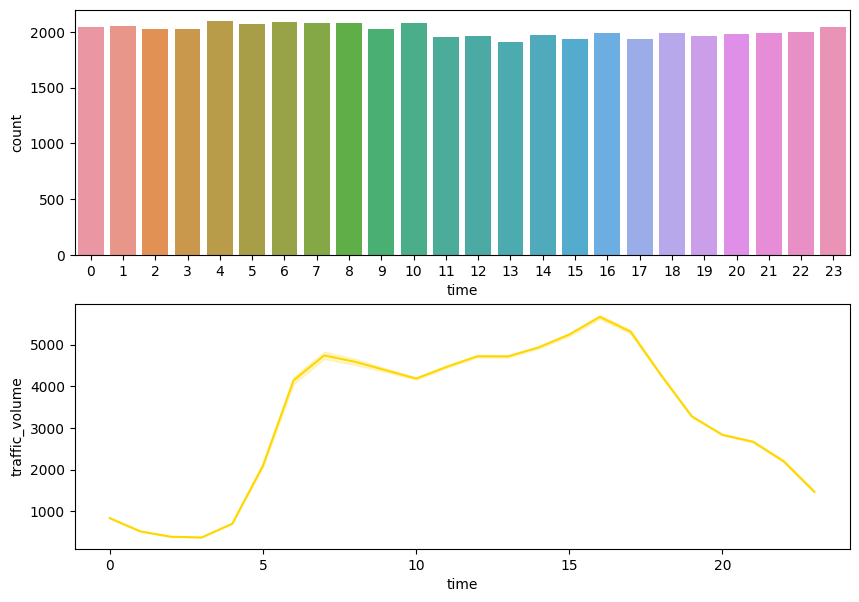

In [13]:
fig, axs = plt.subplots(2, 1, figsize=(10, 7))

sns.countplot(data =df, x= 'time' , ax=axs[0])
sns.lineplot(data =df, x = 'time' , y = 'traffic_volume', color="gold",  ax=axs[1] )


##### Inference :  traffic is much higher in morning and noon time and  decreases as night 

###### month and traffic volume

In [14]:
df['month'] = df['date_time'].dt.month

<AxesSubplot: xlabel='month', ylabel='traffic_volume'>

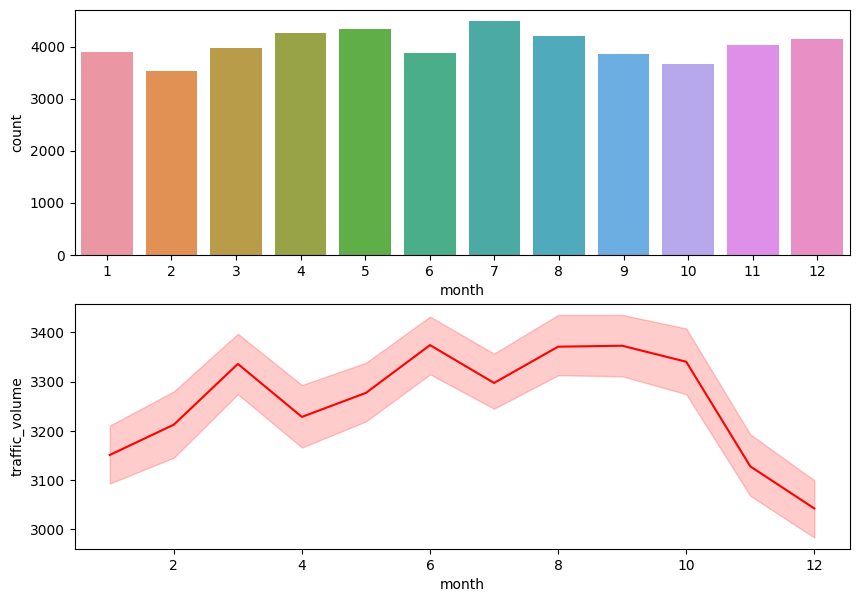

In [15]:
fig, axs = plt.subplots(2, 1, figsize=(10, 7))

sns.countplot(data =df, x= 'month' , ax=axs[0])
sns.lineplot(data =df, x = 'month' , y = 'traffic_volume', color="red",  ax=axs[1] )



##### Inference: Traffic is high when the months are of summer and vice versa

###### Year and traffic volume

In [16]:
df['year'] = df['date_time'].dt.year

<AxesSubplot: xlabel='year', ylabel='traffic_volume'>

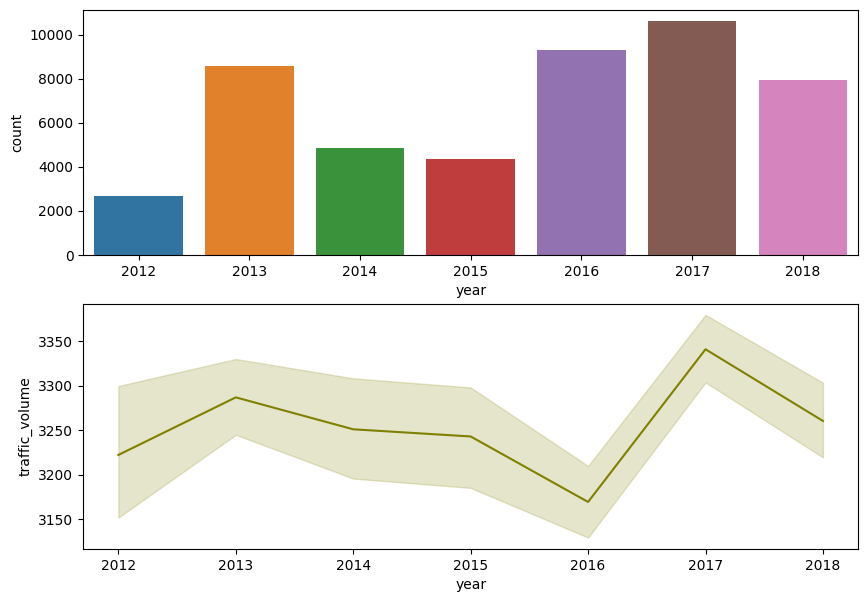

In [17]:
fig, axs = plt.subplots(2, 1, figsize=(10, 7))

sns.countplot(data =df, x= 'year' , ax=axs[0])
sns.lineplot(data =df, x = 'year' , y = 'traffic_volume', color="olive",  ax=axs[1] )



##### Inference : The trafic was largest in year 2017

###### day and traffic_volume

In [18]:
df['day'] = df['date_time'].dt.day_name()

<AxesSubplot: xlabel='day', ylabel='traffic_volume'>

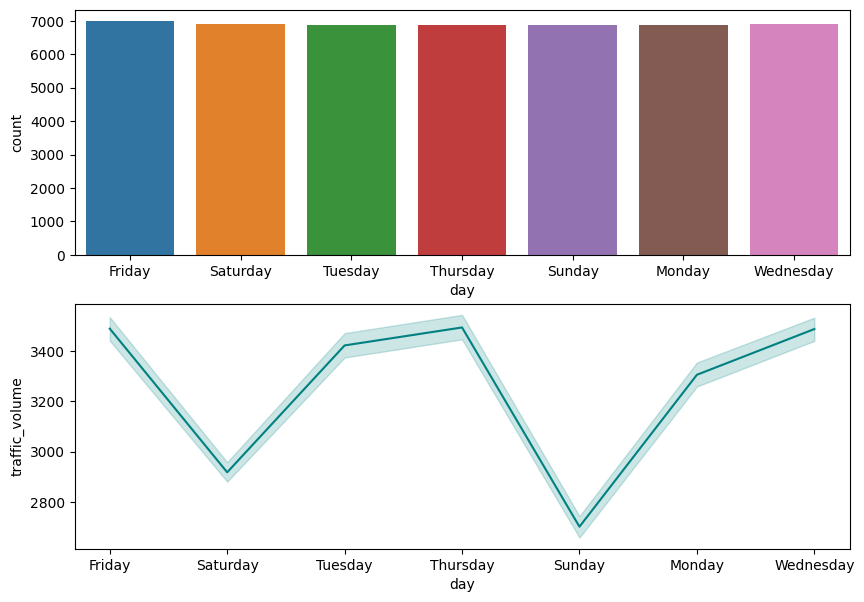

In [19]:
fig, axs = plt.subplots(2, 1, figsize=(10, 7))

sns.countplot(data =df, x= 'day' , ax=axs[0])
sns.lineplot(data =df, x = 'day' , y = 'traffic_volume', color="teal",  ax=axs[1] )

##### Inference : The traffic is lowest at sundays 

###### Holiday and traffic_volume 

In [20]:
df['holiday'].value_counts()

None                         48233
Labor Day                        7
Thanksgiving Day                 6
Christmas Day                    6
New Years Day                    6
Martin Luther King Jr Day        6
Columbus Day                     5
Veterans Day                     5
Washingtons Birthday             5
Memorial Day                     5
Independence Day                 5
State Fair                       5
Name: holiday, dtype: int64

In [21]:
z = lambda x: False if x == 'None' else True
df['holiday'] = df['holiday'].apply(z)

<AxesSubplot: xlabel='holiday', ylabel='traffic_volume'>

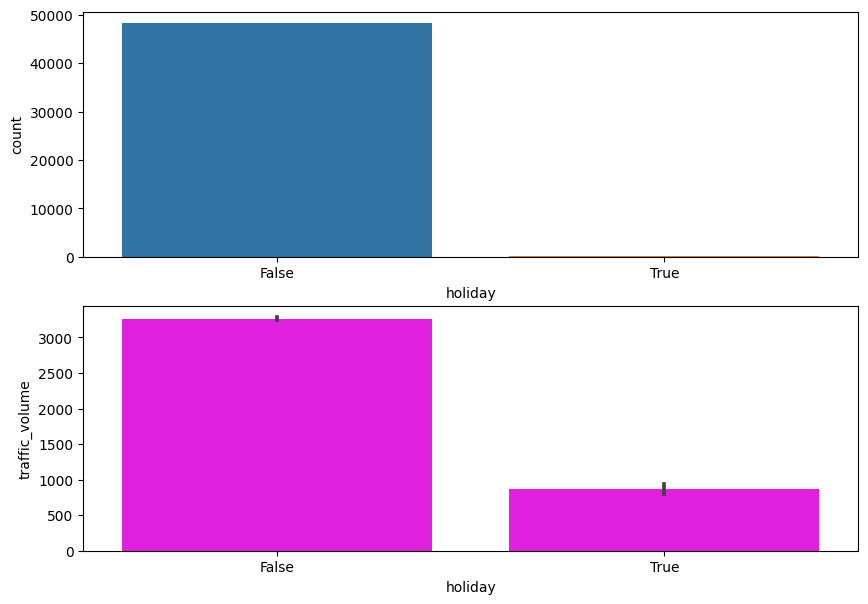

In [22]:
fig, axs = plt.subplots(2, 1, figsize=(10, 7))

sns.countplot(data =df, x= 'holiday' , ax=axs[0])
sns.barplot(data =df, x = 'holiday' , y = 'traffic_volume', color="magenta",  ax=axs[1] )



##### Inference : Traffic on holidays are less

###### Temprature and traffic_volume

In [23]:
(df['temp'] == 0).sum()

10

##### Temprature in kelvin cant be zero

In [24]:
df = df[df['temp'] != 0]

<AxesSubplot: xlabel='temp', ylabel='traffic_volume'>

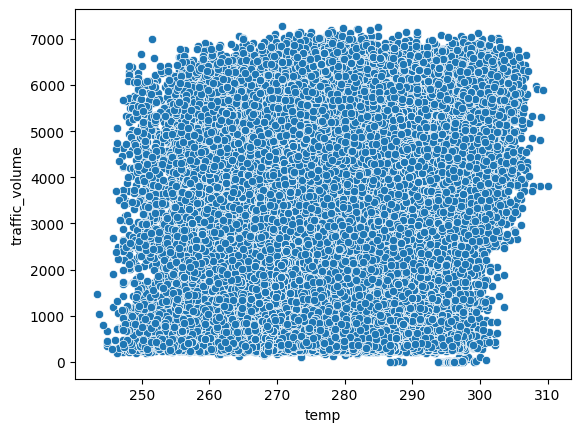

In [25]:
sns.scatterplot(x = 'temp', y = 'traffic_volume', data = df)

###### Rain and traffic_volume

In [26]:
(df['rain_1h'] > 100).sum()

1

##### Inference : As rain described in polts rain values greater than 1 is a outlier

In [27]:
df = df[df.rain_1h < 100]

<AxesSubplot: xlabel='rain_1h', ylabel='traffic_volume'>

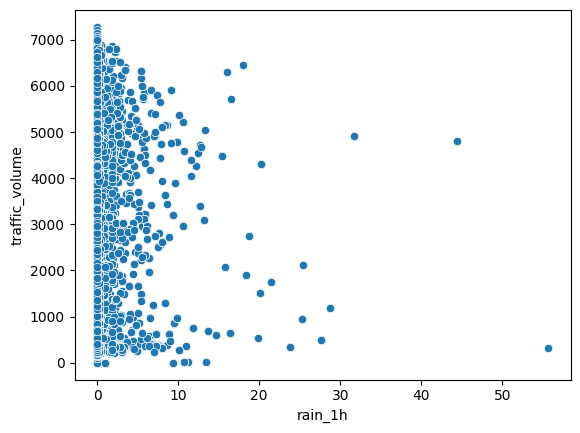

In [28]:
sns.scatterplot(x = 'rain_1h', y = 'traffic_volume', data = df)

###### snow and traffic_volume

<AxesSubplot: xlabel='snow_1h', ylabel='traffic_volume'>

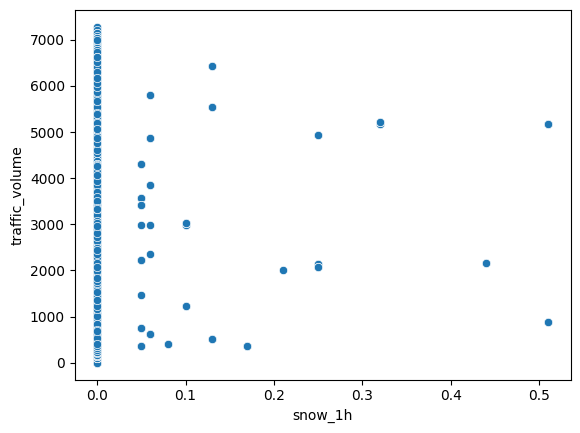

In [29]:
sns.scatterplot(x = 'snow_1h', y = 'traffic_volume', data = df)

###### Clouds and traffic volume 

<AxesSubplot: xlabel='clouds_all', ylabel='traffic_volume'>

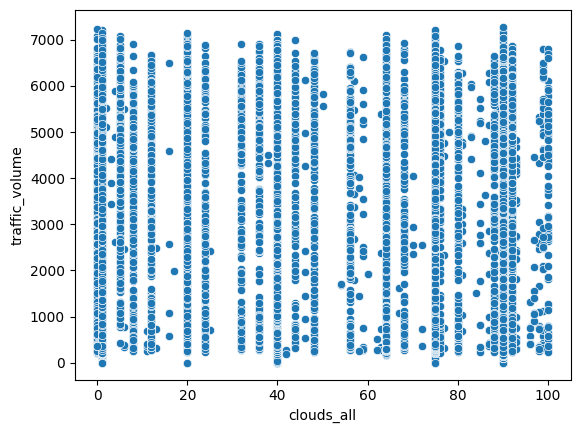

In [30]:
sns.scatterplot(x = 'clouds_all', y = 'traffic_volume', data = df)

###### Weather main ( Short description ) and traffic_volume

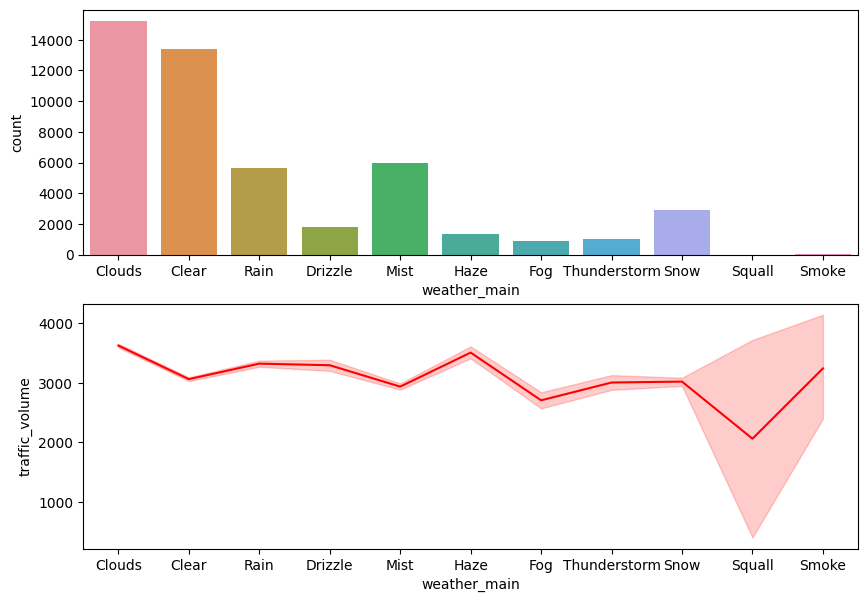

In [31]:
fig, axs = plt.subplots(2, 1, figsize=(10, 7))

sns.countplot(data =df, x= 'weather_main' , ax=axs[0])
sns.lineplot(data =df, x = 'weather_main' , y = 'traffic_volume', color="red",  ax=axs[1] )

plt.savefig('traffic and weather')

###### Weather description ( Long description) versus traffic volume 

In [32]:
df['weather_description'].value_counts()

sky is clear                           11699
mist                                    5950
overcast clouds                         5096
broken clouds                           4678
scattered clouds                        3469
light rain                              3372
few clouds                              1967
light snow                              1946
Sky is Clear                            1726
moderate rain                           1664
haze                                    1360
light intensity drizzle                 1100
fog                                      912
proximity thunderstorm                   673
drizzle                                  651
heavy snow                               616
heavy intensity rain                     467
snow                                     293
proximity shower rain                    136
thunderstorm                             125
heavy intensity drizzle                   64
thunderstorm with heavy rain              63
thundersto

<AxesSubplot: xlabel='weather_description', ylabel='traffic_volume'>

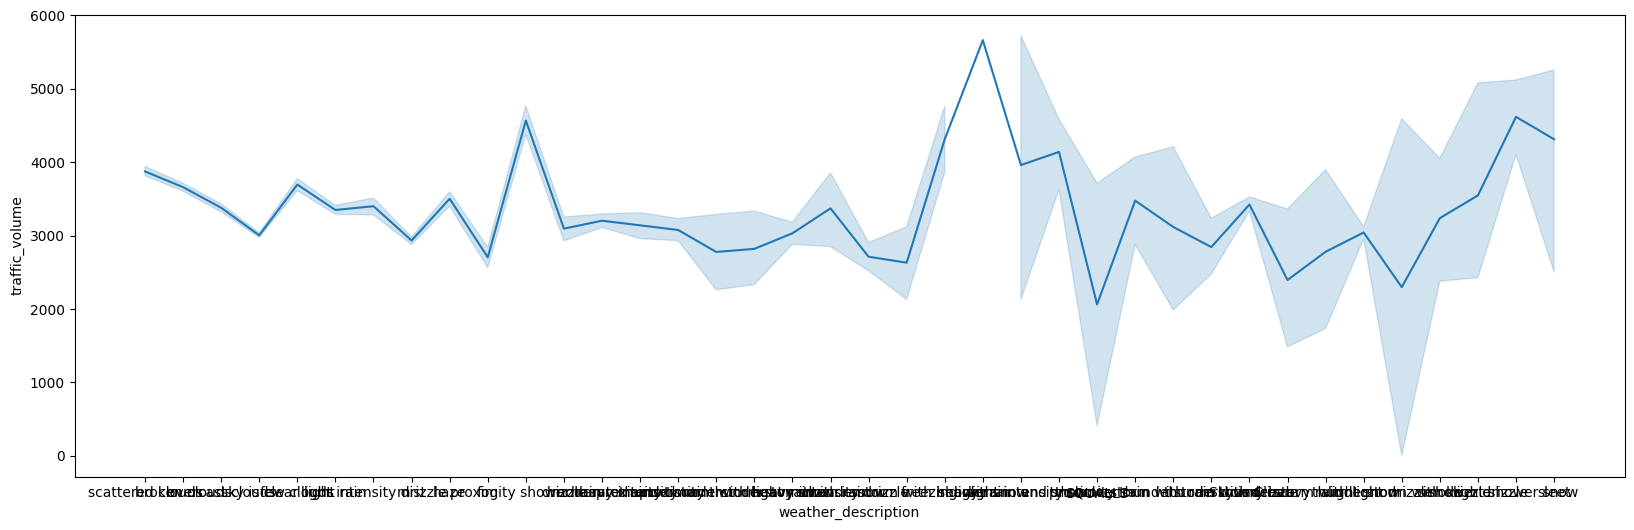

In [33]:
plt.figure(figsize = (20,6))
sns.lineplot(x = 'weather_description', y = 'traffic_volume', data = df)

<AxesSubplot: xlabel='weather_description', ylabel='traffic_volume'>

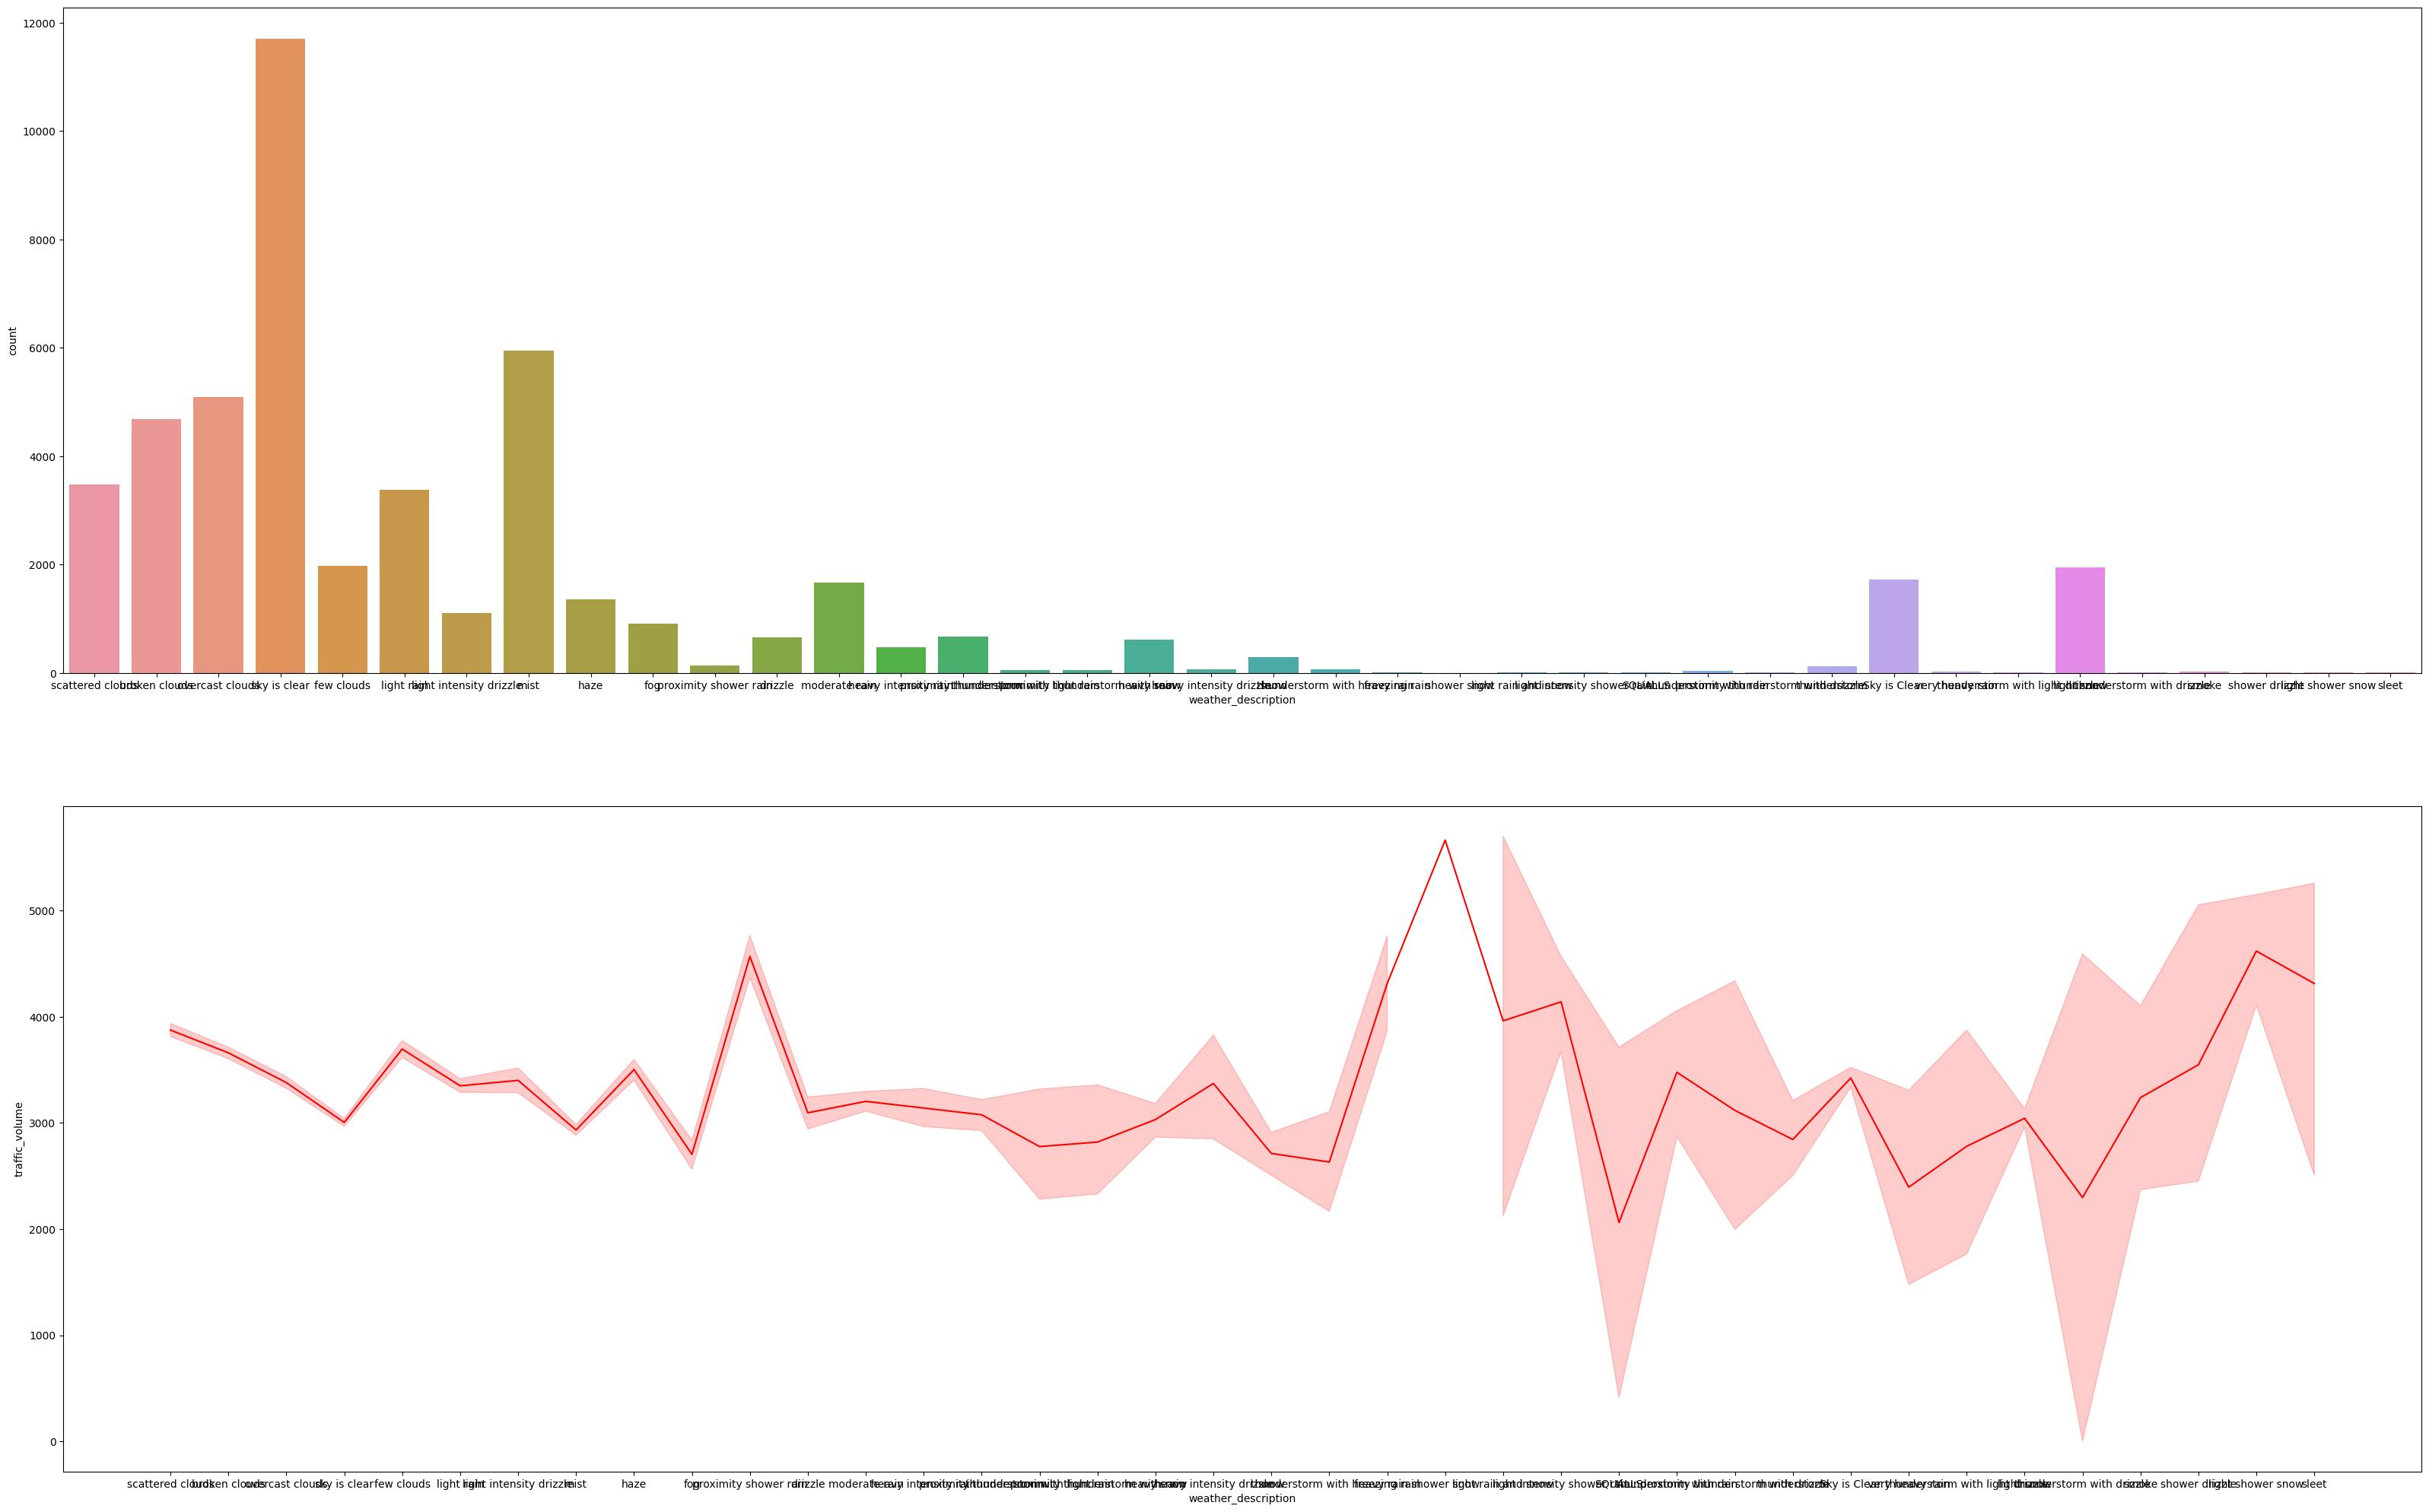

In [34]:
fig, axs = plt.subplots(2, 1, figsize=(40, 25))

sns.countplot( data = df,   x = 'weather_description'    , ax=axs[0]  )
sns.lineplot(  data  =  df,    x = 'weather_description' , y = 'traffic_volume', color="red",  ax=axs[1] )

###### Inference : We can drop this column as this column as we already have weather main. Do not need dublicates column

In [35]:
from sklearn.preprocessing import LabelEncoder
df.drop(['date_time', 'weather_description'], axis = 1, inplace = True)

In [36]:
encoder = LabelEncoder()
df['day'] = encoder.fit_transform(df['day'])

In [37]:
df['temp'] = df['temp'] - 242

In [38]:
encoder = LabelEncoder()
df['weather_main'] = encoder.fit_transform(df['weather_main'])

In [39]:
print(df.head(10))


   holiday   temp  rain_1h  snow_1h  clouds_all  weather_main  traffic_volume  \
0    False  46.28      0.0      0.0          40             1            5545   
1    False  47.36      0.0      0.0          75             1            4516   
2    False  47.58      0.0      0.0          90             1            4767   
3    False  48.13      0.0      0.0          90             1            5026   
4    False  49.14      0.0      0.0          75             1            4918   
5    False  49.72      0.0      0.0           1             0            5181   
6    False  51.17      0.0      0.0           1             0            5584   
7    False  51.86      0.0      0.0           1             0            6015   
8    False  52.14      0.0      0.0          20             1            5791   
9    False  51.10      0.0      0.0          20             1            4770   

   time  month  year  day  
0     9      2  2012    0  
1    10      2  2012    0  
2    11      2  2012    

In [40]:
s1 =  pd.Series(encoder.classes_)
      
s2 = pd.Series(encoder.transform(encoder.classes_)
       )
            
s3 = pd.concat([s1, s2], axis=1)
s3.columns=[['Original','One-Hot-encoded']]
print(s3)

        Original One-Hot-encoded
0          Clear               0
1         Clouds               1
2        Drizzle               2
3            Fog               3
4           Haze               4
5           Mist               5
6           Rain               6
7          Smoke               7
8           Snow               8
9         Squall               9
10  Thunderstorm              10


###### removing dublicates in the dataset

In [41]:
original = df.drop_duplicates()
# Original dataframe will serve as a ground truth to the predicted values.
print(original.shape)
print(original)

(47960, 11)
       holiday   temp  rain_1h  snow_1h  clouds_all  weather_main  \
0        False  46.28      0.0      0.0          40             1   
1        False  47.36      0.0      0.0          75             1   
2        False  47.58      0.0      0.0          90             1   
3        False  48.13      0.0      0.0          90             1   
4        False  49.14      0.0      0.0          75             1   
...        ...    ...      ...      ...         ...           ...   
48200    False  40.76      0.0      0.0          90             1   
48201    False  40.73      0.0      0.0          90            10   
48202    False  40.09      0.0      0.0          90             1   
48203    False  40.12      0.0      0.0          90             1   
48204    False  49.14      0.0      0.0          75             1   

       traffic_volume  time  month  year  day  
0                5545     9      2  2012    0  
1                4516    10      2  2012    0  
2              

In [42]:
original['holiday'] = original['holiday'].apply(lambda x: 1 if x != 'false' else 0 )
original.head()

C:\Users\DELL\AppData\Local\Temp\ipykernel_10560\784800732.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['holiday'] = original['holiday'].apply(lambda x: 1 if x != 'false' else 0 )


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,traffic_volume,time,month,year,day
0,1,46.28,0.0,0.0,40,1,5545,9,2,2012,0
1,1,47.36,0.0,0.0,75,1,4516,10,2,2012,0
2,1,47.58,0.0,0.0,90,1,4767,11,2,2012,0
3,1,48.13,0.0,0.0,90,1,5026,12,2,2012,0
4,1,49.14,0.0,0.0,75,1,4918,13,2,2012,0


In [43]:
num_cols = ['holiday','temp','rain_1h' ,'snow_1h' , 'clouds_all' , 'weather_main' ,'traffic_volume',  'time',  'month',  'year',  'day']

scale = MinMaxScaler()
     
scale.fit(original[num_cols])


n = scale.transform(original[num_cols])


original = pd.DataFrame(data = n, columns = num_cols)
print(original)

       holiday      temp  rain_1h  snow_1h  clouds_all  weather_main  \
0          0.0  0.673215      0.0      0.0        0.40           0.1   
1          0.0  0.689412      0.0      0.0        0.75           0.1   
2          0.0  0.692711      0.0      0.0        0.90           0.1   
3          0.0  0.700960      0.0      0.0        0.90           0.1   
4          0.0  0.716107      0.0      0.0        0.75           0.1   
...        ...       ...      ...      ...         ...           ...   
47955      0.0  0.590432      0.0      0.0        0.90           0.1   
47956      0.0  0.589982      0.0      0.0        0.90           1.0   
47957      0.0  0.580384      0.0      0.0        0.90           0.1   
47958      0.0  0.580834      0.0      0.0        0.90           0.1   
47959      0.0  0.716107      0.0      0.0        0.75           0.1   

       traffic_volume      time     month  year       day  
0            0.761676  0.391304  0.090909   0.0  0.000000  
1            0.

In [44]:
h = pd.read_csv('Data\Potash.csv')

In [45]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest,chi2,RFE
from sklearn.ensemble import RandomForestClassifier
h.drop(columns = 'timestamp',inplace = True)
label = h.temp
df_norm = h.drop(columns = 'q_cms')
rfe = RFE(estimator=KERNEL, n_features_to_select=3)
X_new = rfe.fit_transform(df_norm, label)

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest,chi2,RFE
from sklearn.ensemble import RandomForestClassifier

label = original.traffic_volume
df_norm = original.drop(columns = 'traffic_volume')
rfe = RFE(estimator=KERNEL, n_features_to_select=3)
X_new = rfe.fit_transform(df_norm, label)
print ( rfe.score(df_norm, label) )
print( rfe.get_feature_names_out())

0.9744145459788268
['temp' 'time' 'day']


In [49]:
original = original.dropna().drop_duplicates().reset_index()


df_kc_no_dublicate = original

###### remove warnings and set matplotlib GUI

In [52]:
#df_kc_no_dublicate['traffic_volume'].mean() 

df_kc_no_dublicate['traffic_volume'].mean() 

0.44792533154918485

###### Adding basic threshold column 

In [195]:
df_kc_no_dublicate['Basic_Threshold'] = df_kc_no_dublicate[COL_NAME].apply(lambda row:row < 3260 )
df_kc_no_dublicate['Basic_Threshold'] = df_kc_no_dublicate['Basic_Threshold'].astype(int)

##### preparing numerical columns for LGDI

In [196]:
categories = ['Clouds','Clear','Drizzle','Fog','Haze','Mist','Rain','Smoke','Snow ','Squall','Thunderstorm']

df_kc_no_dublicate1 = df_kc_no_dublicate[['traffic_volume','time','day']]
df_kc_no_dublicate1 = df_kc_no_dublicate1.astype(float)
df_kc_no_dublicate_copy = df_kc_no_dublicate1.copy()


print(df_kc_no_dublicate)
print(df_kc_no_dublicate_copy)

       level_0  index  holiday   temp  rain_1h  snow_1h  clouds_all  \
0            0      0    False  46.28      0.0      0.0          40   
1            1      1    False  47.36      0.0      0.0          75   
2            2      2    False  47.58      0.0      0.0          90   
3            3      3    False  48.13      0.0      0.0          90   
4            4      4    False  49.14      0.0      0.0          75   
...        ...    ...      ...    ...      ...      ...         ...   
47955    47955  48200    False  40.76      0.0      0.0          90   
47956    47956  48201    False  40.73      0.0      0.0          90   
47957    47957  48202    False  40.09      0.0      0.0          90   
47958    47958  48203    False  40.12      0.0      0.0          90   
47959    47959  48204    False  49.14      0.0      0.0          75   

       weather_main  traffic_volume  time  month  year  day  Basic_Threshold  
0                 1            5545     9      2  2012    0         

###### pulling extreme values

In [197]:
results = {'alarms':[], 'normal':[]}
results['alarms'] = df_kc_no_dublicate .index[df_kc_no_dublicate[COL_THRESHOLD]==1].tolist()
print('Total extreme values: ' + str(len ( results['alarms']) ))
# extreme values

Total extreme values: 23297


In [204]:
results1 = {'alarms':[], 'normal':[]}

In [209]:
results1['alarms'] = df_kc_no_dublicate[df_kc_no_dublicate[COL_THRESHOLD]==1]
print(results1['alarms'].traffic_volume)

11       2784
12       2361
13       1529
14        963
15        506
         ... 
47942    2882
47955    2781
47956    2159
47957    1450
47958     954
Name: traffic_volume, Length: 23297, dtype: int64


In [213]:
results1['normal'] = np.setdiff1d(range(total_data_size),results1['alarms'])
# normal values
print('Total normal values: ' + str(len ( results1['normal']) ))

Total normal values: 11667


In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.distplot(x)

###### getting total data size

In [210]:
total_data_size = df_kc_no_dublicate.shape[0]

###### pulling normal values

In [199]:
results['normal'] = np.setdiff1d(range(total_data_size),results['alarms'])
# normal values
print('Total normal values: ' + str(len ( results['normal']) ))


Total normal values: 24663


###### setting size for each cross validation

In [200]:
cv_data_size = int(total_data_size/CV)
print('Each cross validation data size is: ' + str(cv_data_size))


Each cross validation data size is: 9592


In [ ]:
tv = boxcox(df_kc_no_dublicate['traffic_volume'],LMBDA)

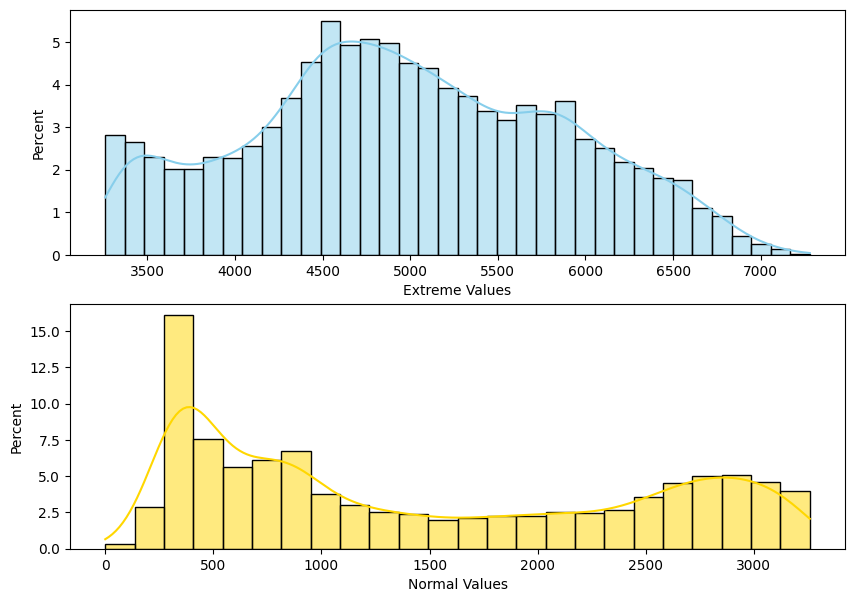

In [291]:
a = results1['alarms'].traffic_volume
n = df_kc_no_dublicate.traffic_volume[results1['normal']]

s3 = pd.concat([n,a],axis=1)
s3.columns = ['Extreme Values','Normal Values' ]

fig, axs = plt.subplots(2, 1, figsize=(10, 7))

sns.histplot(data = s3 , x='Extreme Values', kde=True, color="skyblue", ax=axs[0],   label= 'Normal Values',stat="percent")
sns.histplot(data = s3 , x='Normal Values', kde=True, color="gold",   ax=axs[1],    label=   'Extreme Values',stat="percent")
plt.show()

###### setting evaluation metrics

In [58]:
r_2_list = [] 
# List used to append all the r square values

mse_list = []
# List used to append all the mean squre error values
vis_prediction = []
# List used to append all the prediction values by the model and MICE

vis_gap = []
# List used to append all the gaps of the chunks of the data

x_index = []
# List used to append the index of the values


###### Apply LGDI

In [59]:
for i in range(CV):
    print("currently dealing with loop:", i)
    
    df_no_nan_no_time_backup =df_kc_no_dublicate_copy.copy()
 
    if DATA_TRANSFORM:
        df_no_nan_no_time_backup[COL_NAME] = boxcox(df_no_nan_no_time_backup[COL_NAME],LMBDA)
        

        
    # create holes for all variables
    util.make_holes_matrix(df_no_nan_no_time_backup,HOLE_PERCENT,COL_NAME)
    print("Total number of missing values in the columns:")
    print(df_no_nan_no_time_backup.isna().sum()) 
    
    
    # start and end of continous missing value gap
    start_index = i*cv_data_size
    end_index = start_index + cv_data_size
    print("Start value of the continous missing gap: " + str(start_index))
    print("End value of the continous missing gap: " + str(end_index))


    # create holes for normal and extreme events
    for index in range(start_index, end_index):
        df_no_nan_no_time_backup[COL_NAME].iloc[index] = np.nan
         
        
    # if one row has an extreme event, then treat this line as extreme event
    # if ROW_BASED_RESHAPE == False, this is Col-based LGDI
    # the returned qualified factors are just based on total number of 
    #rows in a file
    # the factor should be better selected based on autocorrelation values
    
    
    
    if ROW_BASED_RESHAPE == False:
        '''The alogrithm is currently applying column based LGDI'''
        
        print('current df shape is:'+str(df_no_nan_no_time_backup.shape))
        '''This is the shape of the dataset that has no timestamp, index and
        threshold.'''
        
        
        # reshape
        reshape_df, factor = util.ccrm(df_no_nan_no_time_backup, RESHAPE_FACTOR)
        '''This piece of code is applying column based LGDI,
        it has converted the dataset that has no index, no threshold, no index
        which has the shape 3160 rows and 11 columns to 1580 rows and 22 columns'''
        
        reshape_normal_row_index_list, reshape_extreme_row_index_list = util.convert_row_index_col_based_reshape(results['alarms'], factor, df_no_nan_no_time_backup.shape[0])
       
        
        if len(reshape_normal_row_index_list) != 0:
            '''After we have normal reshaped index list '''
            df_normal = reshape_df.iloc[reshape_normal_row_index_list]
            df_extreme = reshape_df.iloc[reshape_extreme_row_index_list]
            
            '''This piece of code gets the values of the reshaped normal
            and reshape extreme '''

            imp_normal = IterativeImputer(max_iter=MAX_ITER, estimator=KERNEL)
            imp_extreme = IterativeImputer(max_iter=MAX_ITER, estimator=KERNEL)
            
            '''The imputer here fills the values by machine learning alogrithms
            '''

            array_filled_normal = imp_normal.fit_transform(df_normal)
            array_filled_extreme = imp_extreme.fit_transform(df_extreme)
            
            '''The machine learning alogrithm fits and predicts the values'''

            array_filled = util.combine_normal_extreme(reshape_df.shape[0], reshape_extreme_row_index_list, reshape_normal_row_index_list, array_filled_extreme, array_filled_normal, reshape_df.shape[0],reshape_df.shape[1])
            
            '''This piece of code combines predicted normal,extreme
            and reshaped normal extreme values'''
            
            
            
        else:
            # when no normal events
            df_extreme = reshape_df.iloc[reshape_extreme_row_index_list]
            imp_extreme = IterativeImputer(max_iter=MAX_ITER, estimator=KERNEL)
            array_filled = imp_extreme.fit_transform(df_extreme)

        # reverse reshape
        df_tmp = pd.DataFrame(array_filled)
        original_n1 = df_no_nan_no_time_backup.shape[0]
        original_n2 = df_no_nan_no_time_backup.shape[1]
        original_df = util.ccrm_reverse(df_tmp, original_n1, original_n2)
        array_filled = original_df.to_numpy()
        
        
        
        
        
        
        
    # if ROW_BASED_RESHAPE == True, this is Row-based LGDI
    else:
        print('current df shape is:'+str(df_no_nan_no_time_backup.shape))
        # by default, the minimum factor will be used
        # it means the shape will be balanced (row and col number not too small)
        reshape_df, factor = util.row_based_reshape(df_no_nan_no_time_backup, RESHAPE_FACTOR)

        reshape_normal_row_index_list, reshape_extreme_row_index_list = util.convert_row_index_row_based_reshape(results['alarms'], factor, df_no_nan_no_time_backup.shape[0])

        df_normal = reshape_df.iloc[reshape_normal_row_index_list]
        df_extreme = reshape_df.iloc[reshape_extreme_row_index_list]

        imp_normal = IterativeImputer(max_iter=MAX_ITER, estimator=KERNEL)
        imp_extreme = IterativeImputer(max_iter=MAX_ITER, estimator=KERNEL)

        array_filled_normal = imp_normal.fit_transform(df_normal)
        array_filled_extreme = imp_extreme.fit_transform(df_extreme)

        array_filled = util.combine_normal_extreme(reshape_df.shape[0], reshape_extreme_row_index_list, reshape_normal_row_index_list, array_filled_extreme, array_filled_normal, reshape_df.shape[0],reshape_df.shape[1])
        # # transpose to avoid multiple holes for the same row
        # array_filled = imp.fit_transform(reshape_df.T)
        # array_filled = imp.fit_transform(reshape_df)
        # reverse reshape
        df_tmp = pd.DataFrame(array_filled)
        original_n1 = df_no_nan_no_time_backup.shape[0]
        original_n2 = df_no_nan_no_time_backup.shape[1]

        # original_df = util.row_based_reshape_reverse(df_tmp.T, original_n1, original_n2)
        original_df = util.row_based_reshape_reverse(df_tmp, original_n1, original_n2)
        array_filled = original_df.to_numpy()

        
    #calculate accuracy between backup and df
    ground_truth = []
    prediction = []

    if DATA_TRANSFORM:
        # convert array to float
        array_filled = array_filled.astype(float)
        # back transformation
        # we may generate nan value
        array_filled[:,0] = np.nan_to_num(inv_boxcox(array_filled[:,0],LMBDA))
        # array_filled[:,0] = array_filled[:,0]*10

    for index in range(start_index, end_index):
        # rule 1: prediction should be above 0
        #if array_filled[:,0][index]<0:
            #prediction.append(0)
            #array_filled[:,0][index] = 0
        #else:
        prediction.append(array_filled[:,0][index])
        ground_truth.append(original[COL_NAME].iloc[index])
        # ichanged my dataser
        
        
        
    tmp_r_2 = r2_score(ground_truth.copy(), prediction.copy())
    print("current R2 is", tmp_r_2)
    tmp_mse = mean_squared_error(ground_truth.copy(), prediction.copy())
    print("current mse is", tmp_mse)
    r_2_list.append(tmp_r_2)
    mse_list.append(tmp_mse)
    
    
    if i+1 == VISUALIZE_CHUNK:
        x_index = range(start_index, end_index)
        '''x_index is the list of the start and end chunk'''
        vis_prediction = array_filled[:,0].copy()
        
        vis_gap = df_no_nan_no_time_backup[COL_NAME].copy()
        '''vis_gap is the variable that has the all the gaps that we
        created before the imputation'''

       
    
    
    
    


currently dealing with loop: 0
Total number of missing values in the columns:
traffic_volume        0
time              14395
day               14381
dtype: int64
Start value of the continous missing gap: 0
End value of the continous missing gap: 9592
current df shape is:(47960, 3)
Qualified factors include: [23980, 11990, 9592, 5995, 4796, 4360, 2398, 2180, 1199, 1090, 872, 545, 440, 436, 220, 218, 110, 109, 88, 55, 44, 40, 22, 20, 11, 10, 8, 5, 4, 2]
After reshape, the current shape is:(23980, 6)


C:\Users\DELL\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


current R2 is 0.578489605753868
current mse is 0.03286685183530001
currently dealing with loop: 1
Total number of missing values in the columns:
traffic_volume        0
time              14395
day               14381
dtype: int64
Start value of the continous missing gap: 9592
End value of the continous missing gap: 19184
current df shape is:(47960, 3)
Qualified factors include: [23980, 11990, 9592, 5995, 4796, 4360, 2398, 2180, 1199, 1090, 872, 545, 440, 436, 220, 218, 110, 109, 88, 55, 44, 40, 22, 20, 11, 10, 8, 5, 4, 2]
After reshape, the current shape is:(23980, 6)


C:\Users\DELL\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


current R2 is 0.541481842390171
current mse is 0.03403999915793836
currently dealing with loop: 2
Total number of missing values in the columns:
traffic_volume        0
time              14395
day               14381
dtype: int64
Start value of the continous missing gap: 19184
End value of the continous missing gap: 28776
current df shape is:(47960, 3)
Qualified factors include: [23980, 11990, 9592, 5995, 4796, 4360, 2398, 2180, 1199, 1090, 872, 545, 440, 436, 220, 218, 110, 109, 88, 55, 44, 40, 22, 20, 11, 10, 8, 5, 4, 2]
After reshape, the current shape is:(23980, 6)


C:\Users\DELL\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


current R2 is 0.5810486825287773
current mse is 0.030439781926163454
currently dealing with loop: 3
Total number of missing values in the columns:
traffic_volume        0
time              14395
day               14381
dtype: int64
Start value of the continous missing gap: 28776
End value of the continous missing gap: 38368
current df shape is:(47960, 3)
Qualified factors include: [23980, 11990, 9592, 5995, 4796, 4360, 2398, 2180, 1199, 1090, 872, 545, 440, 436, 220, 218, 110, 109, 88, 55, 44, 40, 22, 20, 11, 10, 8, 5, 4, 2]
After reshape, the current shape is:(23980, 6)


C:\Users\DELL\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


current R2 is 0.6271614347438657
current mse is 0.027705163427216115
currently dealing with loop: 4
Total number of missing values in the columns:
traffic_volume        0
time              14395
day               14381
dtype: int64
Start value of the continous missing gap: 38368
End value of the continous missing gap: 47960
current df shape is:(47960, 3)
Qualified factors include: [23980, 11990, 9592, 5995, 4796, 4360, 2398, 2180, 1199, 1090, 872, 545, 440, 436, 220, 218, 110, 109, 88, 55, 44, 40, 22, 20, 11, 10, 8, 5, 4, 2]
After reshape, the current shape is:(23980, 6)


C:\Users\DELL\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


current R2 is 0.6067148480210796
current mse is 0.028689314402168622


###### Calculating average r^2 and average mse

In [60]:
# calculate R2 value
avg_r2 = sum(r_2_list) / len(r_2_list)
print("average R^2 is: ", avg_r2)
print(r_2_list)
# calculate mse value
avg_mse = sum(mse_list) / len(mse_list)
print("average MSE is: ", avg_mse)
print(mse_list)

average R^2 is:  0.5869792826875523
[0.578489605753868, 0.541481842390171, 0.5810486825287773, 0.6271614347438657, 0.6067148480210796]
average MSE is:  0.030748222149757316
[0.03286685183530001, 0.03403999915793836, 0.030439781926163454, 0.027705163427216115, 0.028689314402168622]


In [75]:
comparison = pd.DataFrame(ground_truth.copy())
comparison1 = pd.DataFrame(prediction.copy())

comparison = comparison *100
comparison1 = comparison1 *100

s = pd.merge(comparison,comparison1,left_index=True, right_index=True)
n = s.rename(columns={"0_x": "Ground_truth", "0_y": "Predicted"})
n['R^2'] = avg_r2
n['MSE'] = avg_mse
n['Kernal'] = 'Gradient_boosting'
n['Hole_percentage'] = HOLE_PERCENT
print(n.head(25))



    Ground_truth  Predicted       R^2       MSE             Kernal  \
0      79.450549  62.119281  0.586979  0.030748  Gradient_boosting   
1      69.862637  56.256480  0.586979  0.030748  Gradient_boosting   
2      64.052198  56.247328  0.586979  0.030748  Gradient_boosting   
3      68.365385  60.135731  0.586979  0.030748  Gradient_boosting   
4      74.217033  61.831111  0.586979  0.030748  Gradient_boosting   
5      75.329670  61.854743  0.586979  0.030748  Gradient_boosting   
6      76.428571  62.161889  0.586979  0.030748  Gradient_boosting   
7      80.494505  61.416296  0.586979  0.030748  Gradient_boosting   
8      69.862637  70.352286  0.586979  0.030748  Gradient_boosting   
9      69.862637  78.261542  0.586979  0.030748  Gradient_boosting   
10     69.862637  79.126137  0.586979  0.030748  Gradient_boosting   
11     74.258242  63.974061  0.586979  0.030748  Gradient_boosting   
12     74.258242  63.974061  0.586979  0.030748  Gradient_boosting   
13     74.258242  46

Text(0.5, 1.0, 'Actual vs prediction')

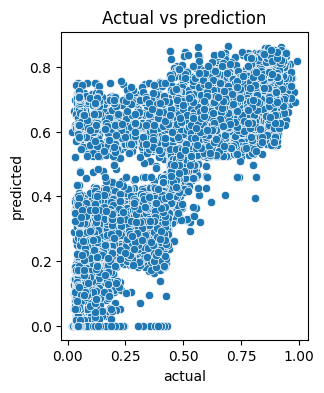

In [77]:
plt.figure(figsize=(7,4))
plt.subplot(1,2,1)
sns.scatterplot(x = ground_truth.copy() , y = prediction.copy() )
plt.xlabel('actual')
plt.ylabel('predicted')
plt.title('Actual vs prediction')

###### Saving the results to a csv file

In [78]:
n.to_csv('gradient_boosting1_y(Traffic_volume)x_(time,day)_Boxcox_', sep = '\t')